<h1> <font color=black> Deep Learning with Python (DLPy) and SAS Viya for Computer Vision </h1>
<h1> <font color=black> Multitask Deep Learning For Image Tagging </h1>

## Introduction to Multitask Learning
-  Multitask Learning :  joint learning, learning to learn, and learning with auxiliary tasks.
Multitask learning is a learning paradigm that aims to leverage useful information in multiple RELATED tasks to help improve overall generalization.  These models can be simpler to deploy and manage because you have just one model for multiple tasks. 


##  Applications

-  Applications: natural language processing, autonomous cars, fashion, etc.

In [1]:
# importing libraries
import swat

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from dlpy import Model, Sequential
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.model import *

In [2]:
# CAS Connection
host_name = 'dlpy'
port = port_no
conn = swat.CAS( host_name, port)

### Loading & Exploring the Images

In [3]:
# loading images
images = ImageTable.load_files(conn, path='/dlpy/data_dir')

In [4]:
# a glance at the loaded images
images.head()

,_image_,_label_,_filename_0,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,blue_shirt,00000059.jpeg,720
1,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...,red_dress,00000081.jpg,271
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,red_dress,00000095.jpg,272
3,b'\xff\xd8\xff\xe1/\x15Exif\x00\x00II*\x00\x08...,black_jeans,00000301.jpg,1626
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,red_dress,00000069.jpg,245


In [5]:
# frequency distribution of the labels
# this data set contains the following categories: 
# black_jeans, blue_dress, blue_jeans, blue_shirt, red_dress, red_shirt
images.freq(inputs='_label_')

,Column,CharVar,FmtVar,Level,Frequency
0,_label_,black_jeans,black_jeans,1,344.0
1,_label_,blue_dress,blue_dress,2,386.0
2,_label_,blue_jeans,blue_jeans,3,356.0
3,_label_,blue_shirt,blue_shirt,4,369.0
4,_label_,red_dress,red_dress,5,378.0
5,_label_,red_shirt,red_shirt,6,332.0


In [6]:
# training a 6-class classifier is an option
# given that the categories have common attributes, we could also extend the labels so that
# we have a better utilization of the labeled data.
# for example, a black_jeans is black, denim, and also jeans.
# the code below help us convert a single category into multiple attributes
retail_data = conn.CASTable(images, 
                            computedVars=['black','blue','red','jeans','dress','shirt','denim','cotton_blend','women'],
                            computedVarsProgram='black=0; blue=0; red=0; jeans=0; \
                            dress=0; shirt=0; denim=0; cotton_blend=0;  women=0; \
                            if (_label_ = "black_jeans") then do; black=1; jeans=1; denim=1; end; \
                            if (_label_ = "blue_dress") then do; blue=1; dress=1; women=1; cotton_blend=1; end; \
                            if (_label_ = "blue_jeans") then do; blue=1; jeans=1; denim=1; end; \
                            if (_label_ = "blue_shirt") then do; blue=1; shirt=1; cotton_blend=1; end; \
                            if (_label_ = "red_dress") then do; red=1; dress=1; women=1; cotton_blend=1; end; \
                            if (_label_ = "red_shirt") then do; red=1; shirt=1; cotton_blend=1; end; \
                            ')

conn.partition(table=retail_data, 
               casout=dict(name='retail_data_joined', replace=True))

images_one = conn.CASTable('retail_data_joined')

In [7]:
images_tbl = ImageTable.from_table(images_one,
                                   image_col='_image_',
                                   label_col='_label_',
                                   columns=['black','blue','red','jeans','dress','shirt','denim','cotton_blend','women'])

In [8]:
# after converting categories into attributes, 
# we also resize the images
images_tbl.resize(width=200, height=200, 
                  columns=['black','blue','red','jeans','dress','shirt','denim','cotton_blend','women'])

In [9]:
images_tbl.head()

,_filename_0,women,denim,cotton_blend,shirt,jeans,black,dress,blue,red,_image_,_id_,_label_
0,00000150.jpeg,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,683,blue_shirt
1,00000061.jpg,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1587,black_jeans
2,00000116.jpg,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,514,blue_shirt
3,00000266.jpg,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1572,black_jeans
4,00000359.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1100,blue_dress


In [10]:
images_tbl.shuffle()

[caslib]

 'CASUSER(ethem-kinginthenorth)'

[tableName]

 '_T_MJAQGP7I_FNK3LSUD_NH6SMFWAVJ'

[casTable]

 CASTable('_T_MJAQGP7I_FNK3LSUD_NH6SMFWAVJ', caslib='CASUSER(ethem-kinginthenorth)')

+ Elapsed: 0.103s, user: 0.0743s, sys: 0.342s, mem: 199mb

In [11]:
# Split Training Data into Train / Test
train_data, test_data = two_way_split(images_tbl, test_rate=20, seed=12345,
                                      columns=['black','blue','red','jeans','dress','shirt','denim','cotton_blend','women'])

### Model creation and training 

In [12]:
# Model Creation
# this is a very simple model, where we have 2 blocks, each of which has a convolution, bn, and pooling layer
# note that we have multiple outputlayers as we now have 9 attributes
# and we are modeling each attribute as a binary classification problem
# as we have 9 attributes we now have 9 binary classifiers that will be trained together
# conventionally we would create 9 different modeling.
# with the ability to do multitask learning, we now can train a single model where
# it traines 9 binary claffiers simultaneously 
inp = Input(3, 200, 200, 
            offsets=train_data.channel_means, 
            name='data')

conv1 = Conv2d(64, 3, include_bias=False, act='identity')(inp)
bn1 = BN(act='relu')(conv1)
pool1 = Pooling(2)(bn1)

conv2 = Conv2d(64, 3,include_bias=False, act='identity')(pool1)
bn2 = BN(act='relu')(conv2)
pool2 = Pooling(2)(bn2)

dense1 = Dense(512)(pool2)

output1 = OutputLayer(n=2, act='softmax', error='entropy', name='output1')(dense1)
output2 = OutputLayer(n=2, act='softmax', error='entropy', name='output2')(dense1)
output3 = OutputLayer(n=2, act='softmax', error='entropy', name='output3')(dense1)
output4 = OutputLayer(n=2, act='softmax', error='entropy', name='output4')(dense1)
output5 = OutputLayer(n=2, act='softmax', error='entropy', name='output5')(dense1)
output6 = OutputLayer(n=2, act='softmax', error='entropy', name='output6')(dense1)
output7 = OutputLayer(n=2, act='softmax', error='entropy', name='output7')(dense1)
output8 = OutputLayer(n=2, act='softmax', error='entropy', name='output8')(dense1)
output9 = OutputLayer(n=2, act='softmax', error='entropy', name='output9')(dense1)

model = Model(conn=conn, inputs=inp, 
              outputs=[output1, output2, output3, output4, output5, output6, output7, output8, output9])
model.compile()

NOTE: Model compiled successfully.


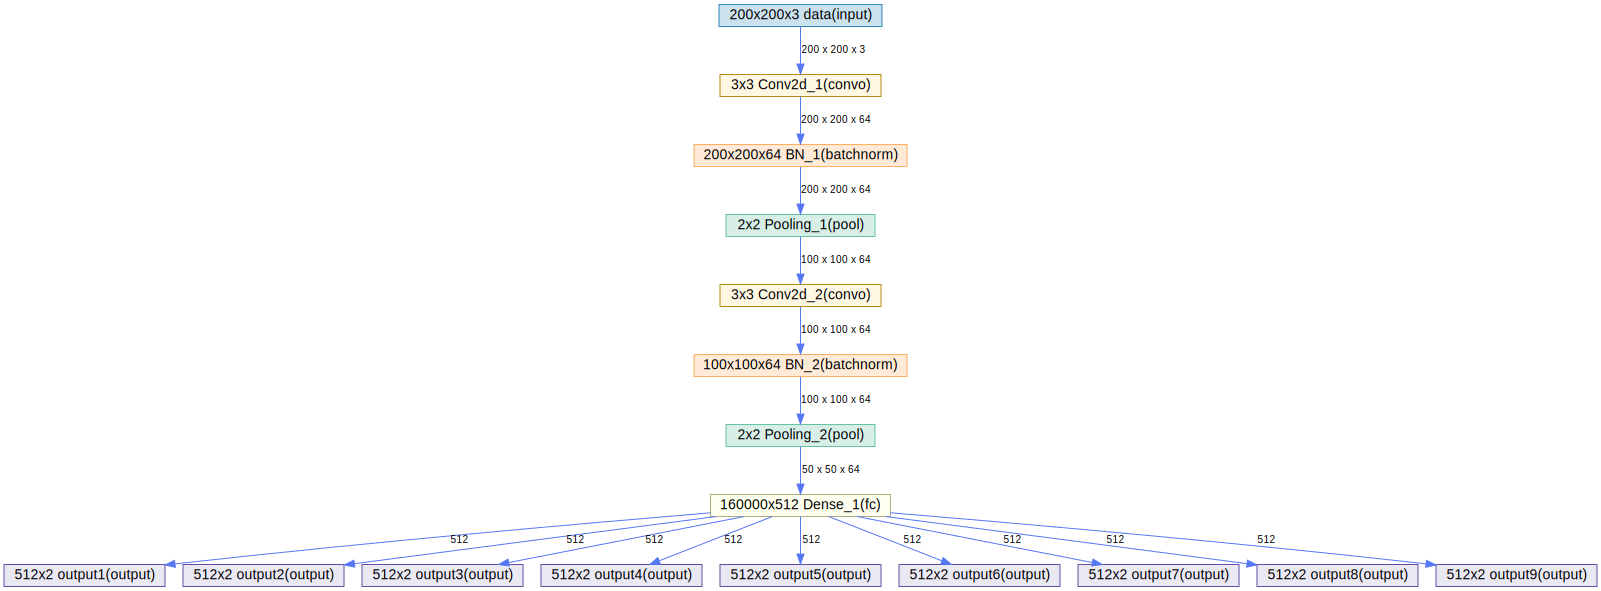

In [13]:
# network topology
model.plot_network()

In [14]:
# Setup model parameters
optimizer = Optimizer(seed=13309,
                      algorithm=MomentumSolver(clip_grad_min=-1000,
                                               clip_grad_max=1000,
                                               learning_rate_policy='step',
                                               gamma=0.1,
                                               step_size=6,
                                               learning_rate=0.00005),
                      max_epochs=10,
                      mini_batch_size=32,
                      reg_l2=0.0001, 
                      log_level=2)
specs=[DataSpec(type_='IMAGE', layer='data', data='_image_'),
       DataSpec(type_='numericnominal', layer='output1', data='black', nominals='black'),
       DataSpec(type_='numericnominal', layer='output2', data='blue', nominals='blue'),
       DataSpec(type_='numericnominal', layer='output3', data='red', nominals='red'),
       DataSpec(type_='numericnominal', layer='output4', data='jeans', nominals='jeans'),
       DataSpec(type_='numericnominal', layer='output5', data='dress', nominals='dress'),
       DataSpec(type_='numericnominal', layer='output6', data='shirt', nominals='shirt'),
       DataSpec(type_='numericnominal', layer='output7', data='denim', nominals='denim'),
       DataSpec(type_='numericnominal', layer='output8', data='cotton_blend', nominals='cotton_blend'),
       DataSpec(type_='numericnominal', layer='output9', data='women', nominals='women')]

model.fit(data=test_data,
          optimizer=optimizer,
          record_seed=54124,
          data_specs=specs,
          seed=1236,
          n_threads=1,
          gpu=Gpu(devices=[1]))

NOTE: Training from scratch.
NOTE: Using dlpy.unx.sas.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 81968594.
NOTE:  The approximate memory cost is 1013.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.73 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Number of output layers (including regression and classification tasks) is   9.
NOTE:  Number of keypoints layers is   0.
NOTE:  Number of detection layers is   0.
NOTE:  Number of segmentation layers is   0.
NOTE:  Number of input variables:     1
NOTE:  Number of nominal input variables:      9
NOTE:  Layer ID:   8 Name: output1 Type: Output Layer
NOTE:  Target variable: black
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the

,Descr,Value
0,Model Name,model_jtjbg9
1,Model Type,Convolutional Neural Network
2,Number of Layers,17
3,Number of Input Layers,1
4,Number of Output Layers,9
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,1
8,Number of Batch Normalization Layers,2
9,Number of Weight Parameters,81967808


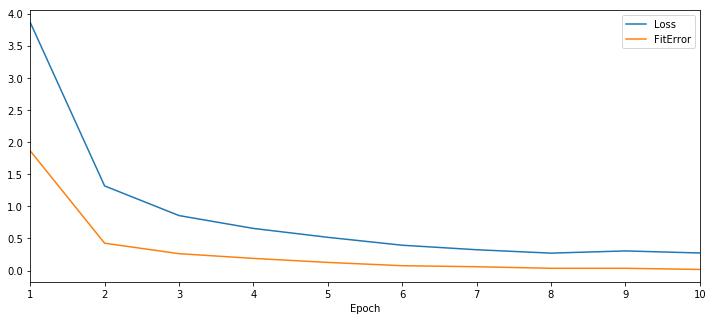

In [15]:
model.plot_training_history()

### Scoring

In [16]:
model.predict(test_data,
              mini_batch_buf_size=5,
              buffer_size=5,
              n_threads=1,
              gpu=Gpu(devices=[1]))

NOTE: Using dlpy.unx.sas.com: 1 out of 2 available GPU devices.


,Descr,Value
0,Number of Observations Read,433
1,Number of Observations Used,433
2,"Misclassification Error (%) (output1, 8)",0.230947
3,"Misclassification Error (%) (output2, 9)",0
4,"Misclassification Error (%) (output3, 10)",0
5,"Misclassification Error (%) (output4, 11)",0.230947
6,"Misclassification Error (%) (output5, 12)",0
7,"Misclassification Error (%) (output6, 13)",0.230947
8,"Misclassification Error (%) (output7, 14)",0.230947
9,"Misclassification Error (%) (output8, 15)",0


In [17]:
model.valid_res_tbl.crosstab(row='black', col='I_black')

,black,Col1,Col2
0,0,364.0,0.0
1,1,1.0,68.0


In [18]:
model.valid_res_tbl.crosstab(row='blue', col='I_blue')

,blue,Col1,Col2
0,0,211.0,0.0
1,1,0.0,222.0


In [19]:
model.valid_res_tbl.crosstab(row='red', col='I_red')

,red,Col1,Col2
0,0,291.0,0.0
1,1,0.0,142.0


In [20]:
model.valid_res_tbl.crosstab(row='jeans', col='I_jeans')

,jeans,Col1,Col2
0,0,292.0,1.0
1,1,0.0,140.0


In [21]:
model.valid_res_tbl.crosstab(row='dress', col='I_dress')

,dress,Col1,Col2
0,0,280.0,0.0
1,1,0.0,153.0


In [22]:
model.valid_res_tbl.crosstab(row='shirt', col='I_shirt')

,shirt,Col1,Col2
0,0,293.0,0.0
1,1,1.0,139.0


In [23]:
model.valid_res_tbl.crosstab(row='denim', col='I_denim')

,denim,Col1,Col2
0,0,292.0,1.0
1,1,0.0,140.0


In [24]:
model.valid_res_tbl.crosstab(row='cotton_blend', col='I_cotton_blend')


,cotton_blend,Col1,Col2
0,0,140.0,0.0
1,1,0.0,293.0


In [25]:
model.valid_res_tbl.crosstab(row='women', col='I_women')

,women,Col1,Col2
0,0,280.0,0.0
1,1,0.0,153.0


###  Save Model as an  ASTORE for Deployment Later

In [26]:
model.deploy(output_format='astore', path='/dlpy/data_dir/')

NOTE: Model astore file saved successfully.


In [27]:
conn.endsession()

+ Elapsed: 0.000243s, user: 0.000211s, mem: 0.204mb